<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/computerVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Testing out CV on NHS computer

In [ ]:
import torch 

print(torch.__version__)

1.13.0+cu116


In [ ]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


trainData = torchvision.datasets.EMNIST(root="data",
                                        split="byclass",
                                        train=True,
                                        transform=ToTensor(),
                                        download=True,
                                        target_transform=None)

testData = torchvision.datasets.EMNIST(root="data",
                                        split="byclass",
                                        train=False,
                                        transform=ToTensor(),
                                        download=True,
                                        target_transform=None)


In [ ]:
classNames = trainData.classes
classNamesToIdx = trainData.class_to_idx

In [ ]:
# creating a plotting function 
import random
import matplotlib.pyplot as plt

def plotRandom(data,
               n = 9):
  
  plt.figure(figsize=(10,10))
  for int in range(n):
    randomInt = random.randint(0,len(data))
    randomImage, randomLabel = data[randomInt]

    plt.subplot(3,3,int+1)
    plt.imshow(randomImage.squeeze(), cmap="gray");
    plt.title(f"EMNIST Dataset | Class: {classNames[randomLabel]} | \nShape  : {randomImage.shape}")
    plt.axis(False);


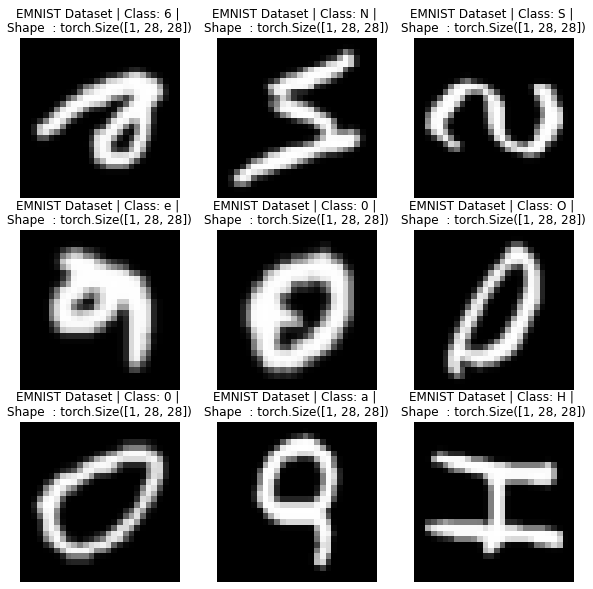

In [ ]:
plotRandom(data=trainData)

## Create DATALOADERS

In [ ]:
from torch.utils.data import DataLoader

batchSize = 32

trainDataLoader = DataLoader(dataset=trainData,
                                 batch_size=batchSize,
                                 shuffle=True)

testDataLoader = DataLoader(dataset=testData,
                            batch_size=32,
                            shuffle=False)

trainDataLoader, testDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x7fd111a0dcd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd16cb687f0>)

## Create a model

In [ ]:
from torch import nn

class EMNISTmodel(nn.Module):
  def __init__(self, inputShape: int, hiddenUnits: int, outputShape: int):
    super().__init__()

    self.ConvBlock1 = nn.Sequential(
        nn.Conv2d(in_channels=inputShape,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3, 
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.ConvBlock2 = nn.Sequential(
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.Classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hiddenUnits*4*4,
                  out_features=outputShape)
    )

  def forward(self, x):
    #print(f"shape before: {x.shape}")
    x = self.ConvBlock1(x)
    #print(f"shape after conv block 1: {x.shape}")
    x = self.ConvBlock2(x)
    #print(f"shape after conv block 2: {x.shape}")
    x = self.Classifier(x)
    return x 

In [ ]:
# instantiate the model
testModel = EMNISTmodel(inputShape=1, 
                        hiddenUnits=10,
                        outputShape=len(classNames))

In [ ]:
dummyX = torch.rand(size=[1,28,28])

testModel(dummyX.unsqueeze(dim=1)).argmax(dim=1)

classNames[3]

'3'

In [ ]:
len(trainDataLoader)

21811

## training loop function

In [ ]:
from tqdm.auto import tqdm 

def trainStep(dataLoader: torch.utils.data.DataLoader,
              model: nn.Module,
              lossFn: nn.Module,
              optimizer: torch.optim.Optimizer,
              device=device):
  """
  performs a training step on the model using dataLoader as the training data
  """
  model.eval()

  trainLoss, trainAccuracy = 0, 0

  for X, y in tqdm(dataLoader):

    X, y = X.to(device), y.to(device)

    # 1. compute the forward pass
    trainLogits = model(X)

    # logits -> test predictions -> labels 
    trainPreds = torch.softmax(trainLogits, dim=1).argmax(dim=1)

    # 2. compute the loss
    loss = lossFn(trainLogits, y)
    trainLoss += loss

    trainAccuracy += (trainPreds==y).sum().item()/len(trainLogits)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. backward pass
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  trainLoss /= len(dataLoader)
  trainAccuracy /= len(dataLoader)

  return {"trainLoss": trainLoss, "trainAccuracy": trainAccuracy}
  

In [ ]:
def testStep(model: nn.Module,
             dataLoader: torch.utils.data.DataLoader,
             lossFn: nn.Module,
             device=device):
  """
  performs a test step and returns the test loss and test accuracy
  """
  
  # model in evalation mode
  model.eval()

  with torch.inference_mode():
    
    testLoss, testAccuracy = 0, 0

    for batch, (X, y) in enumerate(dataLoader):
      X, y = X.to(device), y.to(device)

      # 1. forward pass
      testLogits = model(X)

      # logits -> predictions -> label
      testPreds = torch.softmax(testLogits, dim=1).argmax(dim=1)

      # 2. compute the loss
      testLoss += lossFn(testLogits, y)

      testAccuracy += (testPreds==y).sum().item()/len(testLogits)

    testLoss /= len(dataLoader)
    testAccuracy /= len(dataLoader)

  return {"testLoss": testLoss, "testAccuracy": testAccuracy}

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train(model: nn.Module,
          testDataLoader: torch.utils.data.DataLoader,
          trainDataLoader: torch.utils.data.DataLoader,
          lossFn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device=device):
  
  trainLoss, trainAccuracy = [], []
  testLoss, testAccuracy = [], []
  
  startTime = timer()

  print(f"Training Model: -----{model.__class__.__name__} ------")

  for epoch in tqdm(range(epochs)): 

    trainDict = trainStep(dataLoader=testDataLoader,
              model=model,
              lossFn=lossFn,
              optimizer=optimizer,
              device=device)
    
    testDict = testStep(dataLoader=testDataLoader,
                        model=model,
                        lossFn=lossFn,
                        device=device)
    
    print(f"Epoch: {epoch} | Train loss: {trainDict['trainLoss'].item()} Train Accuracy: {trainDict['trainAccuracy']} |\nTest Loss: {testDict['testLoss'].item()} Test Accuracy {testDict['testAccuracy']}")
    trainLoss.append(trainDict["trainLoss"].item())
    trainAccuracy.append(trainDict["trainAccuracy"])
    testLoss.append(testDict["testLoss"].item())
    testAccuracy.append(testDict["testAccuracy"])
  
  endTime = timer()

  totalTime = endTime - startTime

  results = {"trainLoss": trainLoss, "trainAccuracy": trainAccuracy, "testLoss": testLoss, "testAccuracy": testAccuracy, "totalTime": totalTime, "device": device}

  return results

In [ ]:
model0 = EMNISTmodel(inputShape=1,
                     hiddenUnits=10,
                     outputShape=len(classNames)).to(device)

lossFn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                                  lr=0.1)

In [ ]:
model0Results = train(model=model0,
                      testDataLoader=testDataLoader,
                      trainDataLoader=trainDataLoader,
                      lossFn=lossFn,
                      optimizer=optimizer,
                      epochs=15,
                      device=device)

Training Model: -----EMNISTmodel ------


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9147459268569946 Train Accuracy: 0.7278602860286029 |
Test Loss: 0.7353448867797852 Test Accuracy 0.7808116749174917


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 0.6038568615913391 Train Accuracy: 0.8008800880088008 |
Test Loss: 0.6698578596115112 Test Accuracy 0.798628300330033


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 2 | Train loss: 0.5608046650886536 Train Accuracy: 0.8112451870187019 |
Test Loss: 0.6383156776428223 Test Accuracy 0.8037249037403741


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 3 | Train loss: 0.5370774865150452 Train Accuracy: 0.8164306013934727 |
Test Loss: 0.6378942131996155 Test Accuracy 0.8036217684268426


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 4 | Train loss: 0.5215606093406677 Train Accuracy: 0.82094850110011 |
Test Loss: 0.5734502673149109 Test Accuracy 0.8157831408140814


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 5 | Train loss: 0.5102073550224304 Train Accuracy: 0.823509694719472 |
Test Loss: 0.5704424977302551 Test Accuracy 0.8170981160616062


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 6 | Train loss: 0.5013638138771057 Train Accuracy: 0.8261482398239824 |
Test Loss: 0.5502758622169495 Test Accuracy 0.8209656903190319


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 7 | Train loss: 0.4951382279396057 Train Accuracy: 0.8277554317931793 |
Test Loss: 0.5337756276130676 Test Accuracy 0.8239995874587459


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 8 | Train loss: 0.48961111903190613 Train Accuracy: 0.8293024614961496 |
Test Loss: 0.5265588164329529 Test Accuracy 0.8269389438943895


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 9 | Train loss: 0.4853632152080536 Train Accuracy: 0.8301533278327833 |
Test Loss: 0.509086012840271 Test Accuracy 0.8287438118811881


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 10 | Train loss: 0.4813324809074402 Train Accuracy: 0.8312018701870187 |
Test Loss: 0.5154799222946167 Test Accuracy 0.8261224559955995


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 11 | Train loss: 0.47856125235557556 Train Accuracy: 0.8312878162816282 |
Test Loss: 0.5070253014564514 Test Accuracy 0.8305658690869087


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 12 | Train loss: 0.4768196642398834 Train Accuracy: 0.8319753850385039 |
Test Loss: 0.5102424025535583 Test Accuracy 0.8281164053905391


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 13 | Train loss: 0.47486352920532227 Train Accuracy: 0.8326113861386139 |
Test Loss: 0.49455270171165466 Test Accuracy 0.8318550605060506


  0%|          | 0/3636 [00:00<?, ?it/s]

Epoch: 14 | Train loss: 0.4722859859466553 Train Accuracy: 0.8331356573157316 |
Test Loss: 0.49499884247779846 Test Accuracy 0.8311073294829483


In [ ]:
model0Results

{'trainLoss': [0.9147459268569946,
  0.6038568615913391,
  0.5608046650886536,
  0.5370774865150452,
  0.5215606093406677,
  0.5102073550224304,
  0.5013638138771057,
  0.4951382279396057,
  0.48961111903190613,
  0.4853632152080536,
  0.4813324809074402,
  0.47856125235557556,
  0.4768196642398834,
  0.47486352920532227,
  0.4722859859466553],
 'trainAccuracy': [0.7278602860286029,
  0.8008800880088008,
  0.8112451870187019,
  0.8164306013934727,
  0.82094850110011,
  0.823509694719472,
  0.8261482398239824,
  0.8277554317931793,
  0.8293024614961496,
  0.8301533278327833,
  0.8312018701870187,
  0.8312878162816282,
  0.8319753850385039,
  0.8326113861386139,
  0.8331356573157316],
 'testLoss': [0.7353448867797852,
  0.6698578596115112,
  0.6383156776428223,
  0.6378942131996155,
  0.5734502673149109,
  0.5704424977302551,
  0.5502758622169495,
  0.5337756276130676,
  0.5265588164329529,
  0.509086012840271,
  0.5154799222946167,
  0.5070253014564514,
  0.5102424025535583,
  0.4945527

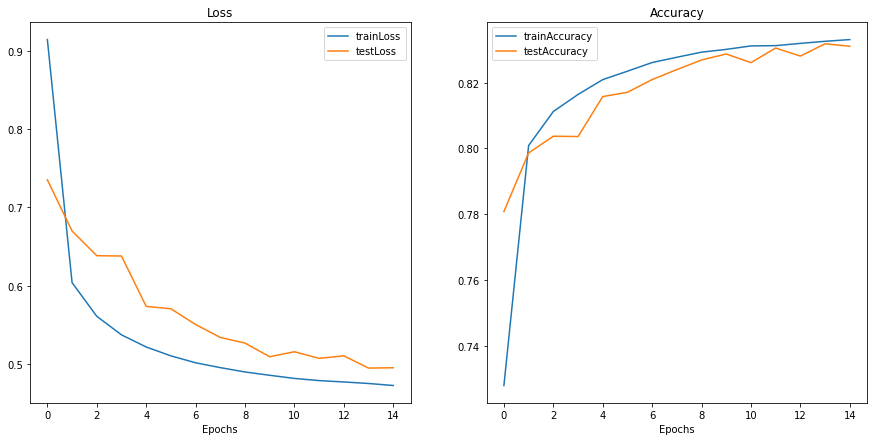

In [ ]:
# visualize results
def plotLossCurves(results):
  """
  Plots training curves of a results dictionary 
  """
  trainLoss = results["trainLoss"]
  testLoss = results["testLoss"]

  trainAccuracy = results["trainAccuracy"]
  testAccuracy = results["testAccuracy"]

  epochs = range(len(results["trainLoss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, trainLoss, label="trainLoss")
  plt.plot(epochs, testLoss, label="testLoss")
  plt.title("Loss");
  plt.xlabel("Epochs")
  plt.legend();

  plt.subplot(1,2,2)
  plt.plot(epochs, trainAccuracy, label="trainAccuracy")
  plt.plot(epochs, testAccuracy, label="testAccuracy")
  plt.title("Accuracy");
  plt.xlabel("Epochs")
  plt.legend();

plotLossCurves(model0Results)

## confusion matrix

In [ ]:
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlx.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend 
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.21.0
mlxtend version: 0.21.0


In [ ]:
from tqdm.auto import tqdm 
model0.eval()
yPreds = []
with torch.inference_mode():
  for X, y in tqdm(testDataLoader):
    X, y = X.to(device), y.to(device)
    yLogits = model0(X)
    yPredLabels = torch.softmax(yLogits, dim=1).argmax(dim=1)
    yPreds.append(yPredLabels)
  yPreds=torch.cat(yPreds).cpu()

  0%|          | 0/3636 [00:00<?, ?it/s]

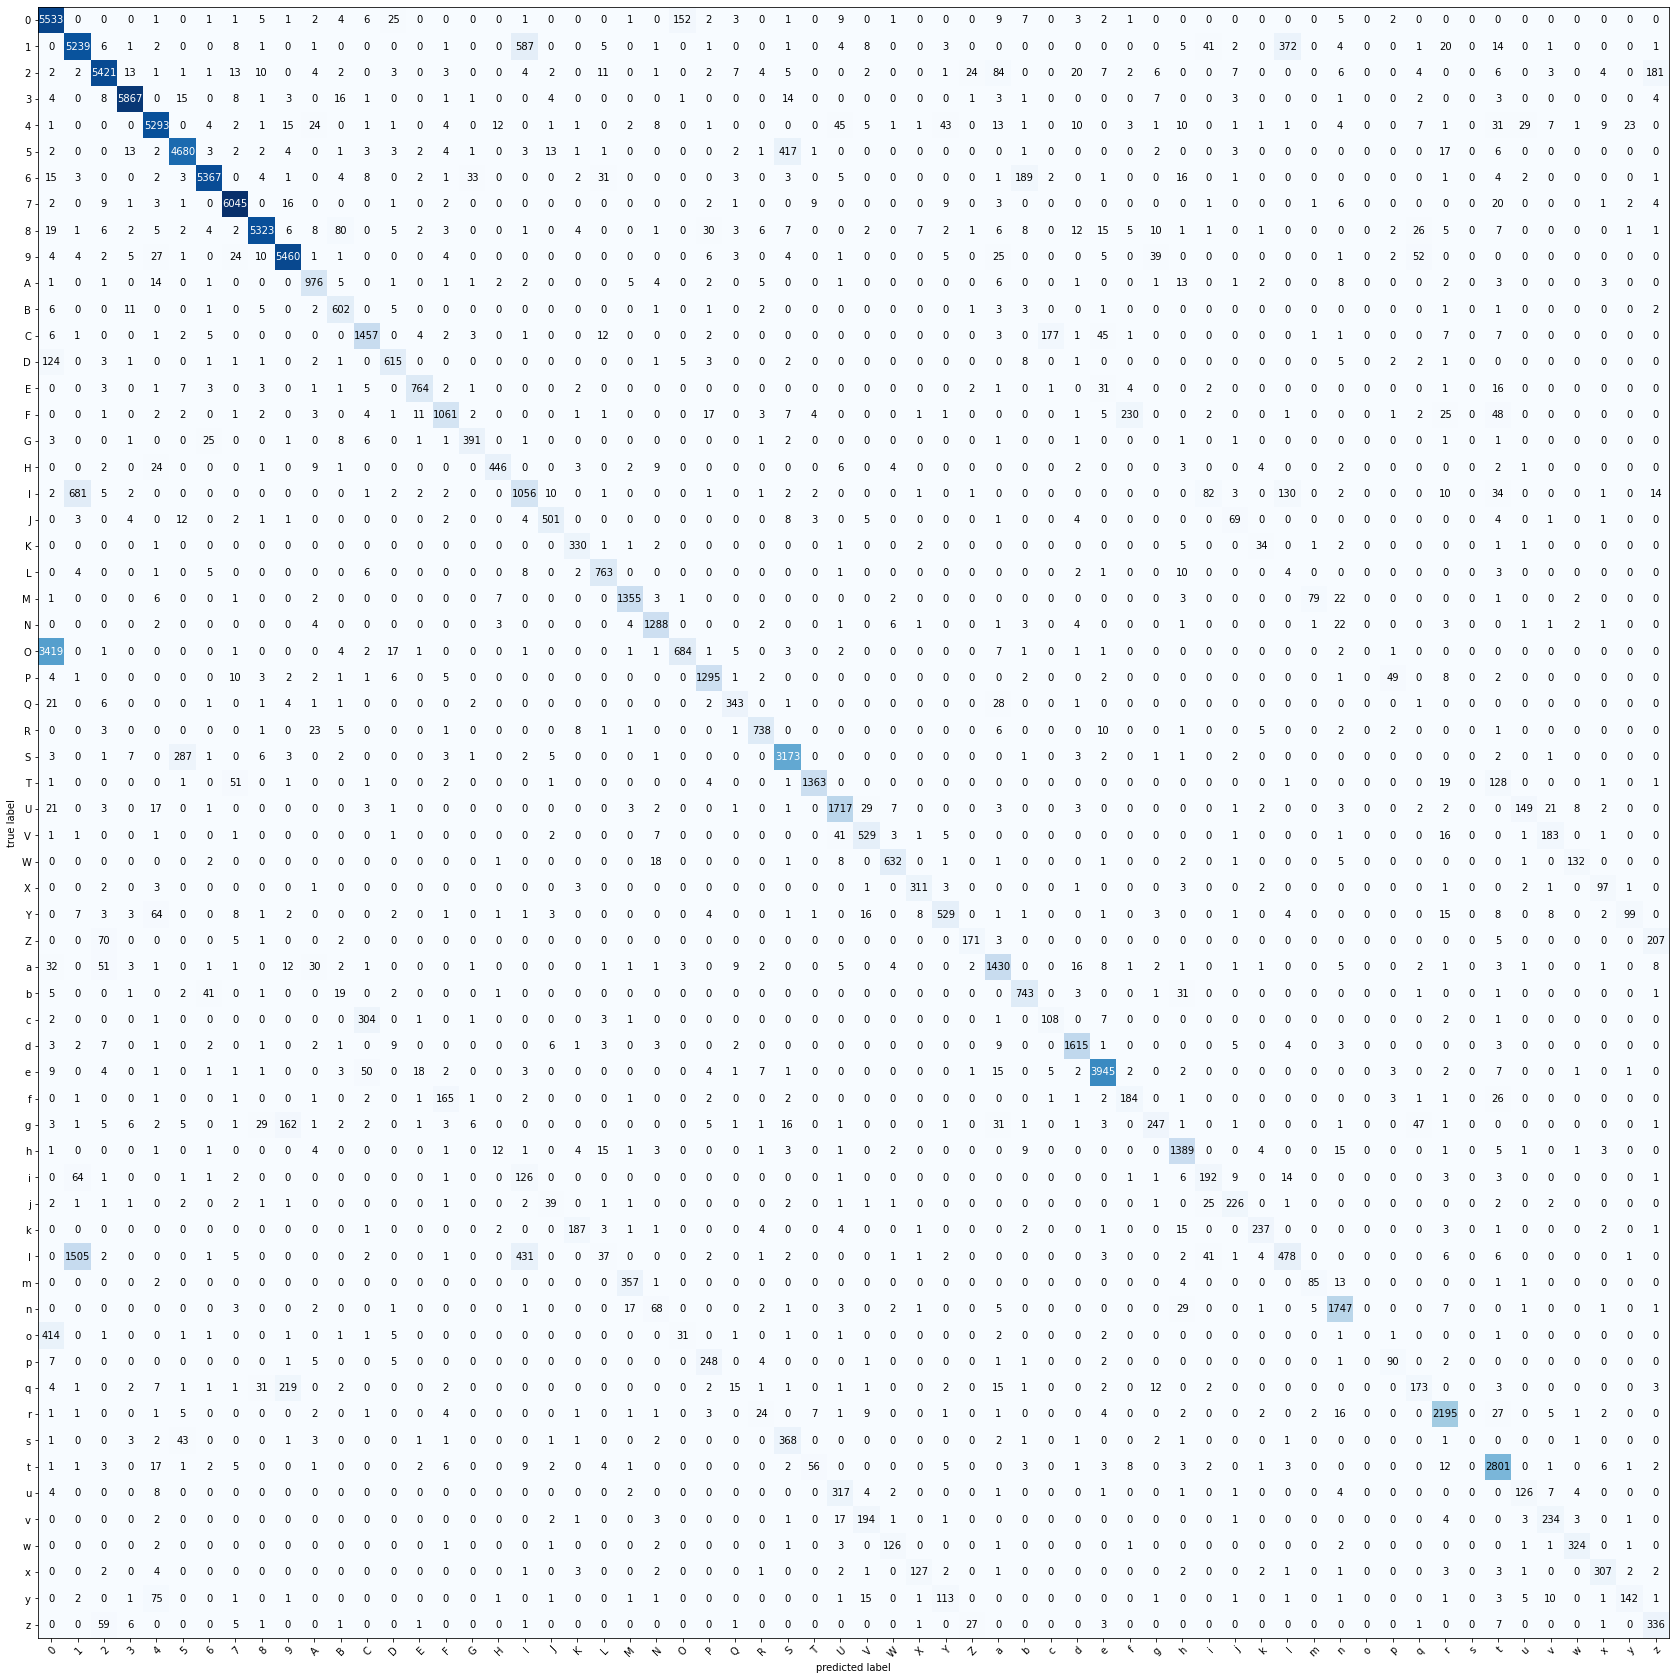

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(classNames), task="multiclass")
confmatTensor = confmat(preds=yPreds,
                        target=testData.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmatTensor.numpy(),
                                class_names=classNames,
                                figsize=(30,30))